# Neoclassical transport for an axisymmetric plasma

Currently a work in progress.

# Houlberg_1997

Equation 6:

$$F_\alpha^{ai} = \int m_a v L_{\alpha-1}^{3/2}(x_a^2)C_{ai} dv$$


$$<F_\alpha^{ai} \cdot B> = \sum_{b,j,\beta} l_{\alpha \beta}^{ai, bj} \hat{u}_\beta^{bj}$$


$$l_{\alpha \beta} ^{ai, bj} = \xi_{ai}(\delta_{ai,bj} M_{\alpha\beta}^a + \xi_{bj} N_{\alpha \beta}^{ab})$$

$$\xi_{ai} = n_{ai} Z_i^2 / \sum_i n_{ai} Z_i^2$$

$$\mu_{\alpha \beta}^{ai} = \frac{8}{3 \sqrt\pi} n_{ai} m_a (-1)^{\alpha + \beta} \times \int_0^\infty dx x^4 e^{-x^2} L_{\alpha-1}^{3/2} L_{\beta-1}^{3/2} \bar{K}^{ai}$$

$$\bar{K}^{ai} = K_B K_{PS} / (K_B + K_{PS})$$
(upuściłem superskrypt ai wszędzie);
$K_B, K_{PS}$ zdefiniowane w appendix B

Equation 23:

$$\sum_\beta (\xi_{ai} M^a_{\alpha \beta} - \hat{\mu}^{ai}_{\alpha\beta}) \hat{\mu}_\beta^{ai} - (\beta_{cx,a} + \beta_{an,\alpha}) \hat{u}_\alpha^{ai} 
= 
- \xi_{ai} =\sum_\beta \sum_b N^{ab}_{\alpha \beta} \bar{\mu}_\beta^b + \sum_\beta \hat{\mu}_{\alpha\beta}^{ai}S_{\theta,\beta}^{ai} - S_{E_\parallel,\alpha}^{ai} - S_{NBI\parallel, \alpha}^{ai}$$

$$\bar{\mu}_\beta^b = \sum_j \xi_{bj} \hat{\mu}_\beta^{bj}$$

Eventually we can go back to $$D^{C,\alpha} = \frac{- \Gamma^{C,\alpha}}{n_c \nabla(\ln \alpha)}$$

for $\alpha \in \{ T_e, T_i, n_e, n_D, n_C \}$

Eq. 41a:

$$\Gamma_{BP}^{ai} = -\hat{F} e_{ai}^{-1} \sum_\beta \hat{\mu}_{1\beta}^{ai} \hat{u}_{\theta,\beta}^{ai}$$

And the other gammas... around eq. 43

TODO assume we can skip heat flows for now. That's 41b

In [13]:
from plasmapy.particles import IonizationStateCollection

all_species = IonizationStateCollection(
    {
        "H": [0, 1],
        #      "D": [0, 1],   raises ParticleError, why?
        "C": [0, 0, 0, 0, 0, 0, 1],
    },
    n0=1e20 * u.m ** -3,
    abundances={"H": 1, "C": 0.08},
    T_e=10 * u.eV,
)
a = all_species["H"]
i = 1
ai = a[i]
all_species["H"].n_e

<Quantity 1.e+20 1 / m3>

In [15]:
h1 = all_species["H"][1]
h1.number_density, h1.T_i

(<Quantity 1.e+20 1 / m3>, <Quantity 116045.1812155 K>)

# Flux surface

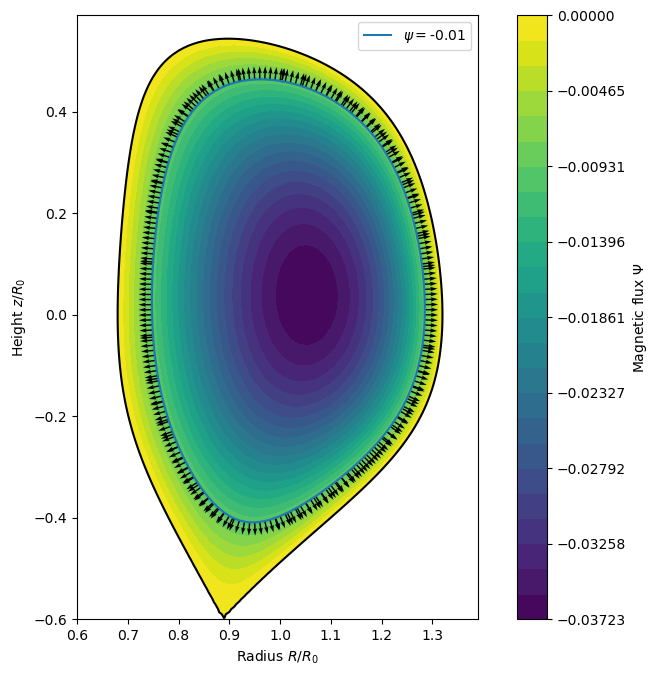

In [16]:
import plasmaboundaries

from plasmapy.plasma.symbolicequilibrium import SymbolicEquilibrium

params = plasmaboundaries.ITER.copy()
assert params["triangularity"] <= 0.841  # for convex plasma surfaces
eq = SymbolicEquilibrium(**params, B0=5.2, config="single-null")
ax = eq.plot()
fs = eq.get_flux_surface(-0.01)
fs.plot(ax, n=True);

# Appendix B

### F_m and its unknown values

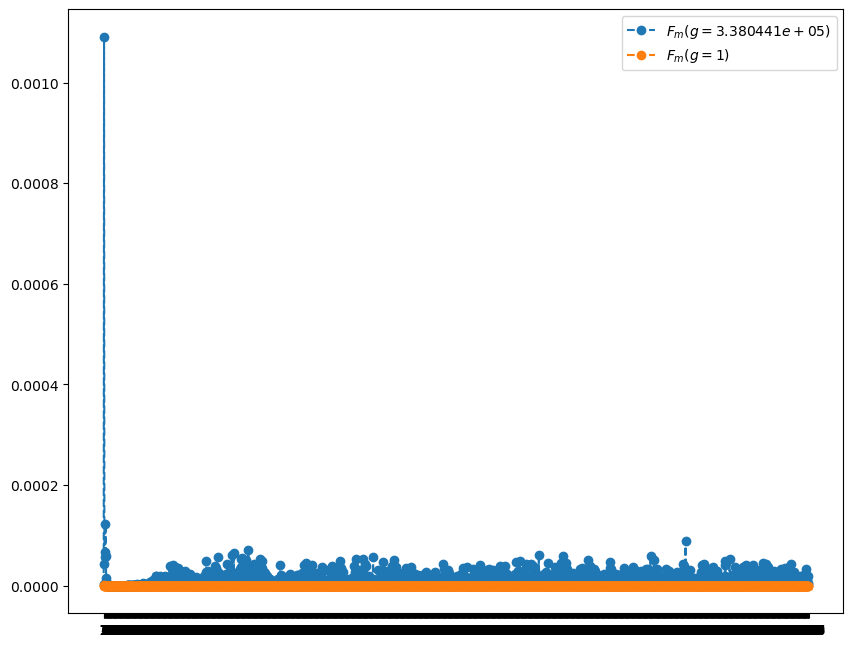

In [19]:
num_m = 1000


from plasmapy.formulary.neoclassical import F_m

def optimizer(g):
    mrange = range(1, num_m)
    F_ms = np.array([F_m(m, fs, g) for m in mrange])
    diff = F_ms.sum() - B17
    return diff ** 2


from scipy import optimize

optimization = optimize.minimize_scalar(optimizer)
mrange = range(1, 2 * num_m)
F_ms = np.array([F_m(m, fs, optimization.x) for m in mrange])
plt.plot(F_ms, "o--", label=fr"$F_m(g={optimization.x:e})$")
plt.plot(np.array([F_m(m, fs, 1) for m in mrange]), "o--", label=r"$F_m(g=1)$")
plt.xticks(mrange)
plt.legend()

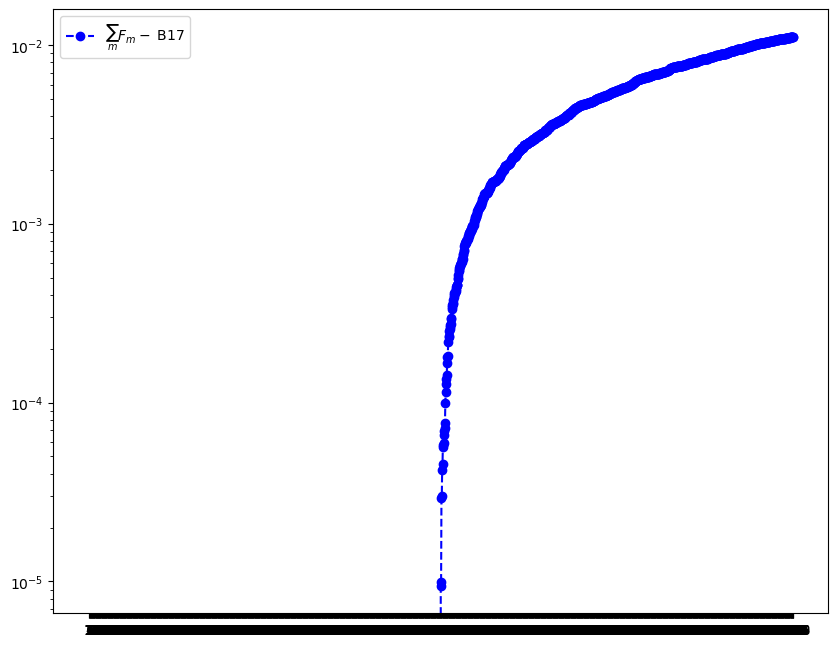

In [20]:
cumsum = np.cumsum(F_ms)

plt.plot(cumsum - B17, "bo--", label=r"$\sum_m F_m -$ B17")
# plt.axhline(0, color="black"
#            )
plt.yscale("log")
plt.xticks(mrange)
plt.legend()

So this probably sucks as a solution, a little.

In [29]:
from plasmapy.formulary.neoclassical import K_ps_ai


K_ps_ai(1, 1, a, all_species, fs, g=optimization.x)

<Quantity 5703947.12413714 m2 / s>

In [30]:
from plasmapy.formulary.neoclassical import K_B_ai

In [31]:
K_B_ai(1, 1, a, all_species, fs)

<Quantity 10340684.63637584 1 / s>

$$[K_B^{ai}] = \frac{1}{1} \frac{[\nu_{D,ai}]}{1}$$

$$[\nu_{D,ai}] = s^{-1}$$

In [32]:
from plasmapy.formulary.neoclassical import ν_T_ai

ν_T_ai(1, 1, a, all_species)

<Quantity 24638301.15254432 1 / s>

In [33]:
from plasmapy.formulary.neoclassical import mu_hat

In [ ]:
mu_hat(1, a, all_species, fs, g = optimization.x)

/usr/lib/python3.9/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/hdd/Code/github/PlasmaPy/PlasmaPy/plasmapy/formulary/neoclassical.py:336: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = integrate.quad(integrand, 0, np.inf)


In [ ]:
%timeit mu_hat(1, a, all_species, fs, g = optimization.x)